In [1]:
""" 
Author: maxwell.cook@colorado.edu
"""

import os, sys, gc, time
import geopandas as gpd
import rasterio as rio
import rioxarray as rxr
import seaborn as sns
import matplotlib.pyplot as plt

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/data/')

print("Ready to go !")

Ready to go !


In [ ]:
# Load the VIIRS active fire detections gridded data

In [2]:
fp = os.path.join(projdir,f'spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_aspenfires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
grid.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'frp_csum',
       'frp_max', 'frp_min', 'frp_p90', 'frp_first', 'day_max_frp',
       'dt_max_frp', 'first_obs_date', 'last_obs_date', 'day_count',
       'night_count', 'frp_max_day', 'frp_max_night', 'frp_p90_day',
       'frp_p90_night', 'frp_first_day', 'frp_first_night', 'Fire_ID',
       'Fire_Name', 'geometry'],
      dtype='object')

In [3]:
print(f"There are [{len(grid['Fire_ID'].unique())}] fire events in the Southern Rockies (2018-2023)")
print(f"\tWith {len(grid)} gridcells.")

There are [58] fire events in the Southern Rockies (2018-2023)
	With 49047 gridcells.


In [4]:
bounds = grid.total_bounds # for cropping the raster data

# USFS TreeMap (2016) Summaries

From Earth Engine, the forest type percent cover for each gridcell was calculated. From this, we also gathered the "all forest" percent. Then, within a mask for each species, the TreeMap metrics (e.g., BALIVE) were summarized. Finally, within each species mask the Sentinel-2 LAI and MNDWI averages were gathered.

In [10]:
# Load the summary table (from GEE reductions)
fp = os.path.join(projdir,'earth-engine/exports/treemap/gridstats_fortypcd.csv')
fortypcd = pd.read_csv(fp)
fortypcd.drop(columns=['system:index','.geo'], inplace=True) # drop the GEE id and .geo columns
fortypcd.head()

,grid_index,species_histogram,total_pixels
0,919906,"182:3.0941176470588236, 185:7.0, 221:41.768627...",196.949020
1,919907,"182:9.227450980392156, 221:75.02745098039216, ...",197.176471
2,919908,"182:15.611764705882354, 185:10.996078431372549...",196.960784
3,922166,"182:8.36078431372549, 184:16.83137254901961, 1...",197.176471
4,922171,"182:9.768627450980393, 184:2.0, 185:4.05098039...",197.466667


In [11]:
print(fortypcd['species_histogram'].head())
print(fortypcd['species_histogram'].map(type).value_counts())

0    182:3.0941176470588236, 185:7.0, 221:41.768627...
1    182:9.227450980392156, 221:75.02745098039216, ...
2    182:15.611764705882354, 185:10.996078431372549...
3    182:8.36078431372549, 184:16.83137254901961, 1...
4    182:9.768627450980393, 184:2.0, 185:4.05098039...
Name: species_histogram, dtype: object
species_histogram
<class 'str'>      48777
<class 'float'>      270
Name: count, dtype: int64


In [12]:
# unpack histogram dictionary into columns
def parse_histogram(hist_str):
    # Convert float or NaN to string, then parse
    if isinstance(hist_str, float) or pd.isna(hist_str):
        hist_str = str(int(hist_str)) if not pd.isna(hist_str) else ""
    kv_pairs = hist_str.split(', ')  # Split the key-value pairs
    # Convert key-value pairs to a dictionary
    return {int(kv.split(':')[0]): float(kv.split(':')[1]) for kv in kv_pairs if ':' in kv}

# parse the dictionary
fortypcd['species_histogram'] = fortypcd['species_histogram'].apply(parse_histogram)

hist_df = fortypcd['species_histogram'].apply(pd.Series)
fortypcd = pd.concat([fortypcd.drop(columns=['species_histogram']), hist_df], axis=1).reset_index(drop=True)
print("Adjusted DataFrame:")
fortypcd.head()

Adjusted DataFrame:


,grid_index,total_pixels,182,185,221,225,369,371,901,971,...,367,801,995,171,923,263,805,976,507,924
0,919906,196.949020,3.094118,7.000000,41.768627,36.423529,2.674510,11.607843,0.494118,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,919907,197.176471,9.227451,NaN,75.027451,32.870588,12.109804,6.827451,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,919908,196.960784,15.611765,10.996078,37.329412,15.466667,12.000000,2.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,922166,197.176471,8.360784,46.721569,44.247059,9.231373,20.058824,NaN,NaN,12.411765,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,922171,197.466667,9.768627,4.050980,72.717647,34.400000,8.690196,9.603922,1.000000,1.996078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Pivot longer and join to get species name
fortypcd_l = fortypcd.melt(id_vars=['grid_index','total_pixels'], var_name='FORTYPCD', value_name='count')
fortypcd_l['FORTYPCD'] = fortypcd_l['FORTYPCD'].astype(int)

# Drop 'NaN' counts (species not present in the AFD)
fortypcd_l.dropna(subset=['count'], inplace=True)
fortypcd_l.sort_values(by=['grid_index'], inplace=True)
print("Dropped NA values.")
print(fortypcd_l.columns)
fortypcd_l.head(3)

Dropped NA values.
Index(['grid_index', 'total_pixels', 'FORTYPCD', 'count'], dtype='object')


,grid_index,total_pixels,FORTYPCD,count
83805,184440,199.756863,185,123.662745
476181,184440,199.756863,184,15.968627
83806,184441,199.482353,185,114.670588


In [15]:
# load the species lookup table
fp = os.path.join(projdir,'tabular/mod/treemap_fortypcd_species_mapping.csv')
species_df = pd.read_csv(fp)
species_df = species_df[['FORTYPCD','SpeciesName']]
species_df = species_df[species_df['FORTYPCD'].isin(fortypcd_l['FORTYPCD'].unique())]
print(species_df.columns)

# merge with grid summary to get forest species name
fortypcd_l_ = fortypcd_l.merge(species_df, on='FORTYPCD', how='left')
fortypcd_l_.head(3)

Index(['FORTYPCD', 'SpeciesName'], dtype='object')


,grid_index,total_pixels,FORTYPCD,count,SpeciesName
0,184440,199.756863,185,123.662745,Pinyon / juniper woodland
1,184440,199.756863,184,15.968627,Juniper woodland
2,184441,199.482353,185,114.670588,Pinyon / juniper woodland


In [16]:
# print a unqiue list of tree species
fortypcd_l_['SpeciesName'].unique()

array(['Pinyon / juniper woodland', 'Juniper woodland',
       'Mesquite woodland', 'Other exotic hardwoods', 'Cottonwood',
       'Deciduous oak woodland', 'Rocky Mountain juniper',
       'Ponderosa pine', 'Western juniper', 'Other hardwoods',
       'Sugarberry / hackberry / elm / green ash', 'Nonstocked',
       'Douglas-fir', 'Cottonwood / willow', 'Bur oak',
       'Western redcedar', 'Grand fir', 'Aspen', 'White fir',
       'Cercocarpus (mountain brush) woodland', 'Lodgepole pine',
       'Engelmann spruce', 'Western larch',
       'Intermountain maple woodland', 'Engelmann spruce / subalpine fir',
       'Subalpine fir', 'Blue spruce', 'Limber pine',
       'Foxtail pine / bristlecone pine', 'Balsam fir', 'Paper birch',
       'Miscellaneous western softwoods', 'Noble fir',
       'Sugar maple / beech / yellow birch', 'Hard maple / basswood',
       'California mixed conifer', 'Jeffrey pine',
       'Evergreen oak woodland', 'Eastern redcedar / hardwood',
       'Elm / ash / b

In [17]:
# calculate the total forest count and percent cover for each species
forest_count = fortypcd_l_.groupby('grid_index')['count'].sum().reset_index()
forest_count = forest_count.rename(columns={'count': 'forest_pix'})

# Join back to the data frame, calculate percent cover
fortypcd_l_pct = fortypcd_l_.merge(forest_count, on='grid_index', how='left')

fortypcd_l_pct['spp_pct'] = (fortypcd_l_pct['count'] / fortypcd_l_pct['forest_pix']) * 100
fortypcd_l_pct['forest_pct'] = (fortypcd_l_pct['forest_pix'] / fortypcd_l_pct['total_pixels']) * 100

# reshape the columns
cols = ['grid_index', 'FORTYPCD', 'SpeciesName', 'count', 'forest_pix', 'total_pixels', 'spp_pct', 'forest_pct']
fortypcd_l_pct = fortypcd_l_pct[cols]

# check the results
fortypcd_l_pct = fortypcd_l_pct.sort_values(by=['grid_index'])
print(fortypcd_l_pct.columns)
fortypcd_l_pct.head(3)

Index(['grid_index', 'FORTYPCD', 'SpeciesName', 'count', 'forest_pix',
       'total_pixels', 'spp_pct', 'forest_pct'],
      dtype='object')


,grid_index,FORTYPCD,SpeciesName,count,forest_pix,total_pixels,spp_pct,forest_pct
0,184440,185,Pinyon / juniper woodland,123.662745,139.631373,199.756863,88.563725,69.900664
1,184440,184,Juniper woodland,15.968627,139.631373,199.756863,11.436275,69.900664
2,184441,185,Pinyon / juniper woodland,114.670588,118.909804,199.482353,96.434932,59.609185


In [ ]:
# Create a histogram of the forest species (prevalence)



Species making up 97% of the total: 

                         SpeciesName         count  fraction  c_fraction
27                    Lodgepole pine  2.408028e+06  0.294627    0.294627
40                    Ponderosa pine  1.613215e+06  0.197380    0.492007
0                              Aspen  9.797278e+05  0.119872    0.611878
18  Engelmann spruce / subalpine fir  9.040129e+05  0.110608    0.722486
13                       Douglas-fir  4.746550e+05  0.058075    0.780561
39         Pinyon / juniper woodland  3.094141e+05  0.037857    0.818418
17                  Engelmann spruce  3.032830e+05  0.037107    0.855526
46                     Subalpine fir  2.284919e+05  0.027956    0.883482
21                         Grand fir  1.917080e+05  0.023456    0.906938
53                         White fir  1.721483e+05  0.021063    0.928001
12            Deciduous oak woodland  1.257371e+05  0.015384    0.943385
43            Rocky Mountain juniper  1.201248e+05  0.014697    0.958082
6          

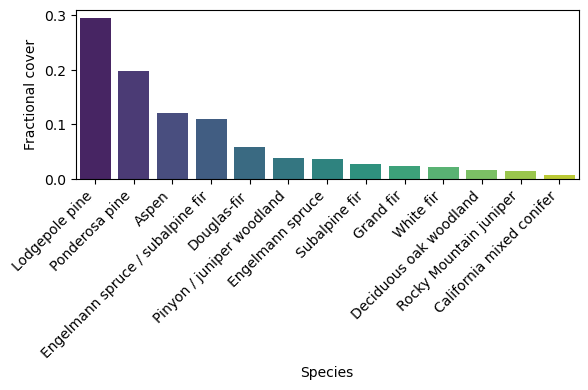

In [18]:
fortyp_df = fortypcd_l_pct.copy() # make a copy to work with
fortyp_df = fortyp_df[fortyp_df['count'] > 0] # make sure there are some pixels

# calculate the landscape fraction (prevalence)
spp_prevalence = fortyp_df.groupby('SpeciesName')['count'].sum().reset_index()
spp_prevalence['fraction'] = spp_prevalence['count'] / spp_prevalence['count'].sum()
spp_prevalence = spp_prevalence.sort_values(by='fraction', ascending=False)

# which species make up 97% of observations?
spp_prevalence['c_fraction'] = spp_prevalence['fraction'].cumsum()
top_species = spp_prevalence[spp_prevalence['c_fraction'] <= 0.97]
print(f"\n\nSpecies making up 97% of the total: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='SpeciesName', y='fraction', palette='viridis')
plt.xlabel('Species')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# perform a remap for some forest types
# create a 'Spruce-fir' category
# 'Pinon-juniper woodland' category

In [19]:
spp_remap = {
    'Engelmann spruce': 'Spruce-fir',
    'Subalpine fir': 'Spruce-fir',
    'White fir': 'Spruce-fir',
    'Grand fir': 'Spruce-fir',
    'Engelmann spruce / subalpine fir': 'Spruce-fir',
    'Western juniper': 'Pinon-juniper woodland',
    'Rocky Mountain juniper': 'Pinon-juniper woodland',
    'Pinyon / juniper woodland': 'Pinon-juniper woodland',
    'Juniper woodland': 'Pinon-juniper woodland'
}

# Add a new column for the merged categories
fortyp_df['SpeciesName'] = fortyp_df['SpeciesName'].map(spp_remap).fillna(fortyp_df['SpeciesName'])
fortyp_df['SpeciesName'].unique()

array(['Pinon-juniper woodland', 'Cottonwood', 'Other exotic hardwoods',
       'Mesquite woodland', 'Deciduous oak woodland', 'Ponderosa pine',
       'Sugarberry / hackberry / elm / green ash', 'Other hardwoods',
       'Nonstocked', 'Douglas-fir', 'Cottonwood / willow', 'Bur oak',
       'Western redcedar', 'Spruce-fir', 'Aspen',
       'Cercocarpus (mountain brush) woodland', 'Lodgepole pine',
       'Western larch', 'Intermountain maple woodland', 'Blue spruce',
       'Limber pine', 'Paper birch', 'Balsam fir',
       'Foxtail pine / bristlecone pine',
       'Miscellaneous western softwoods', 'Noble fir',
       'Sugar maple / beech / yellow birch', 'Hard maple / basswood',
       'California mixed conifer', 'Jeffrey pine',
       'Evergreen oak woodland', 'Eastern redcedar / hardwood',
       'Elm / ash / black locust', 'Willow', 'Red alder',
       'Southwestern white pine', 'California black oak', 'White spruce',
       'Sugar pine', 'Mountain hemlock', 'Canyon live oak',
   



Species making up 97% of the total: 

               SpeciesName         count  fraction  c_fraction
23          Lodgepole pine  2.408028e+06  0.294627    0.294627
41              Spruce-fir  1.799644e+06  0.220190    0.514817
36          Ponderosa pine  1.613215e+06  0.197380    0.712197
0                    Aspen  9.797278e+05  0.119872    0.832068
35  Pinon-juniper woodland  5.301839e+05  0.064869    0.896937
13             Douglas-fir  4.746550e+05  0.058075    0.955012




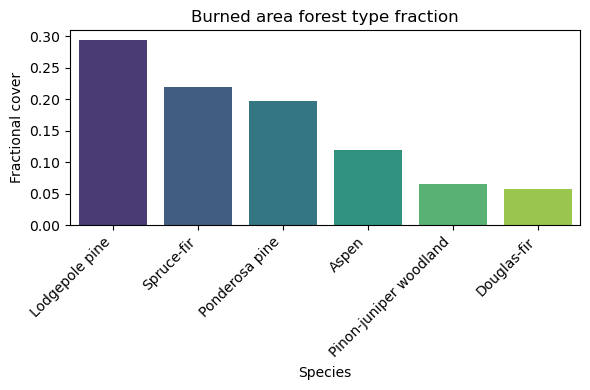

In [20]:
# re-plot the dataframe
# Calculate the total percent cover (prevalence)
spp_prevalence = fortyp_df.groupby('SpeciesName')['count'].sum().reset_index()
spp_prevalence['fraction'] = spp_prevalence['count'] / spp_prevalence['count'].sum()
spp_prevalence = spp_prevalence.sort_values(by='fraction', ascending=False)

# which species make up 97% of observations?
spp_prevalence['c_fraction'] = spp_prevalence['fraction'].cumsum()
top_species = spp_prevalence[spp_prevalence['c_fraction'] <= 0.97]
print(f"\n\nSpecies making up 97% of the total: \n\n{top_species}\n\n")

# plot it
plt.figure(figsize=(6, 4))
sns.barplot(data=top_species, x='SpeciesName', y='fraction', palette='viridis')
plt.title('Burned area forest type fraction')
plt.xlabel('Species')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# join the forest type dataframe to our FRP gridcells

In [21]:
grid_ = grid.merge(fortyp_df, on='grid_index', how='left')
grid_.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'frp_csum',
       'frp_max', 'frp_min', 'frp_p90', 'frp_first', 'day_max_frp',
       'dt_max_frp', 'first_obs_date', 'last_obs_date', 'day_count',
       'night_count', 'frp_max_day', 'frp_max_night', 'frp_p90_day',
       'frp_p90_night', 'frp_first_day', 'frp_first_night', 'Fire_ID',
       'Fire_Name', 'geometry', 'FORTYPCD', 'SpeciesName', 'count',
       'forest_pix', 'total_pixels', 'spp_pct', 'forest_pct'],
      dtype='object')

In [22]:
# subset the grids to predominantly forested plots (>50% forested)
grid_forest = grid_[grid_['forest_pct'] > 50]
print(f"{len(grid_forest['grid_index'].unique())}/{len(grid)} [{round(len(grid_forest['grid_index'].unique())/len(grid)*100,1)}%] gridcells are forested.")

41955/49047 [85.5%] gridcells are forested.


In [23]:
print(top_species['SpeciesName'].unique()) # check on our top species
# subset columns in our forested gridcells to retain just our top species
grid_forest = grid_forest[grid_forest['SpeciesName'].isin(top_species['SpeciesName'].unique())]
len(grid_forest['grid_index'].unique())

['Lodgepole pine' 'Spruce-fir' 'Ponderosa pine' 'Aspen'
 'Pinon-juniper woodland' 'Douglas-fir']


41955

In [ ]:
# Load the treemap metrics, apply the same remapping

In [24]:
ftyp_met = os.path.join(projdir,'earth-engine/exports/treemap/gridstats_fortypcd_metrics.csv')
tm_stats = pd.read_csv(ftyp_met)
tm_stats.drop(columns=['system:index','.geo'], inplace=True)
tm_stats.columns

Index(['grid_index', 'species_metrics'], dtype='object')

In [25]:
# unpack histogram dictionary into columns
def parse_histogram(hist_str):
    # Convert float or NaN to string, then parse
    if isinstance(hist_str, float) or pd.isna(hist_str):
        hist_str = str(int(hist_str)) if not pd.isna(hist_str) else ""
    kv_pairs = hist_str.split(', ')  # Split the key-value pairs
    # Convert key-value pairs to a dictionary
    return {kv.split(':')[0]: float(kv.split(':')[1]) for kv in kv_pairs if ':' in kv}

# parse the dictionary
tm_stats['species_metrics'] = tm_stats['species_metrics'].apply(parse_histogram)
hist_df = tm_stats['species_metrics'].apply(pd.Series)
tm_stats = pd.concat([tm_stats.drop(columns=['species_metrics']), hist_df], axis=1).reset_index(drop=True)
print("Adjusted DataFrame:")
tm_stats.head(3)

Adjusted DataFrame:


,grid_index,182_BALIVE_mn,182_SDIPCT_RMRS_mn,182_STANDHT_mn,182_TPA_DEAD_mn,182_TPA_LIVE_mn,185_BALIVE_mn,185_SDIPCT_RMRS_mn,185_STANDHT_mn,185_TPA_DEAD_mn,...,976_BALIVE_mn,976_STANDHT_mn,976_TPA_DEAD_mn,976_TPA_LIVE_mn,507_BALIVE_mn,507_STANDHT_mn,507_TPA_LIVE_mn,924_BALIVE_mn,924_STANDHT_mn,924_TPA_LIVE_mn
0,919906,113.513901,65.199997,29.0,12.036092,396.670441,44.991299,26.083333,20.285714,9.027069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,919907,113.513901,65.199997,29.0,12.036092,396.670441,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,919908,63.252056,33.140844,29.0,12.036092,146.540987,52.111698,25.000000,30.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# isolate melt bands/columns
band_names = ['BALIVE', 'SDIPCT_RMRS', 'STANDHT', 'TPA_DEAD', 'TPA_LIVE']
regex_p = '|'.join(band_names) # regex pattern for melting columns
metrics_cols = [col for col in tm_stats.columns if '_mn' in col]
print(f"[{len(metrics_cols)}] total metrics columns selected for melting:\n")

# do the melt
tm_stats_l = tm_stats.melt(
    id_vars=['grid_index'], 
    value_vars=metrics_cols, 
    var_name='metric', 
    value_name='value'
)
tm_stats_l.head(3)

[257] total metrics columns selected for melting:



,grid_index,metric,value
0,919906,182_BALIVE_mn,113.513901
1,919907,182_BALIVE_mn,113.513901
2,919908,182_BALIVE_mn,63.252056


In [27]:
# gather the forest type code from the band name
tm_stats_l['FORTYPCD'] = tm_stats_l['metric'].str.extract(r'^(\d+)_')[0].astype(int)
tm_stats_l['metric'] = tm_stats_l['metric'].str.extract(f'({regex_p})')[0]
tm_stats_l = tm_stats_l[['grid_index','FORTYPCD','metric','value']]
tm_stats_l.dropna(subset=['value'], inplace=True) # drop NaNs
tm_stats_l['metric'].unique()

array(['BALIVE', 'SDIPCT_RMRS', 'STANDHT', 'TPA_DEAD', 'TPA_LIVE'],
      dtype=object)

In [28]:
# pivot longer to get metrics as columns
tm_stats_lp = tm_stats_l.pivot_table(index=['grid_index', 'FORTYPCD'], columns='metric', values='value')
tm_stats_lp = tm_stats_lp.reset_index() # collapse the index
tm_stats_lp = tm_stats_lp[['grid_index','FORTYPCD']+band_names]
tm_stats_lp.rename(columns={'SDIPCT_RMRS': 'SDIPCT'}, inplace=True)
tm_stats_lp.head(3)

metric,grid_index,FORTYPCD,BALIVE,SDIPCT,STANDHT,TPA_DEAD,TPA_LIVE
0,184440,184,28.642924,12.543885,12.183448,6.018046,36.084544
1,184440,185,46.993341,18.682264,15.118729,12.178753,141.248148
2,184441,184,72.685503,32.056522,14.415356,9.027069,78.017484


In [ ]:
# load the Sentinel-2 metrics

In [ ]:
fp = os.path.join(projdir,'earth-engine/exports/treemap/gridstats_fortypcd_s2.csv')
s2_stats = pd.read_csv(fp)
s2_stats.drop(columns=['system:index','.geo'], inplace=True)
s2_stats.columns

In [ ]:
# unpack histogram dictionary into columns
def parse_histogram(hist_str):
    # Convert float or NaN to string, then parse
    if isinstance(hist_str, float) or pd.isna(hist_str):
        hist_str = str(int(hist_str)) if not pd.isna(hist_str) else ""
    kv_pairs = hist_str.split(', ')  # Split the key-value pairs
    # Convert key-value pairs to a dictionary
    return {kv.split(':')[0]: float(kv.split(':')[1]) for kv in kv_pairs if ':' in kv}
# parse the dictionary
s2_stats['species_s2'] = s2_stats['species_s2'].apply(parse_histogram)
s2_stats.head(3)

In [ ]:
hist_df = s2_stats['species_s2'].apply(pd.Series)
s2_stats = pd.concat([s2_stats.drop(columns=['species_s2']), hist_df], axis=1).reset_index(drop=True)
print("Adjusted DataFrame:")
s2_stats.head(3)

In [ ]:
# extract the correct band names / columns
band_names = ['LAI', 'MNDWI']
regex_p = '|'.join(band_names) # regex pattern for melting columns
metrics_cols = [col for col in s2_stats.columns if 'LAI' or 'MNDWI' in col]
print(f"[{len(metrics_cols)}] total metrics columns selected for melting:\n")
# do the melt
s2_stats_l = s2_stats.melt(
    id_vars=['grid_index'], 
    value_vars=metrics_cols, 
    var_name='metric', 
    value_name='value'
)
s2_stats_l.head(3)

In [ ]:
# gather the forest type code
s2_stats_l['FORTYPCD'] = s2_stats_l['metric'].str.extract(r'^(\d+)_')[0].astype(int)
s2_stats_l['metric'] = s2_stats_l['metric'].str.extract(f'({regex_p})')[0]
s2_stats_l = s2_stats_l[['grid_index','FORTYPCD','metric','value']]
s2_stats_l.dropna(subset=['value'], inplace=True) # drop NaNs
s2_stats_l['metric'].unique()

In [ ]:
# pivot longer the get metrics as columns
s2_stats_lp = s2_stats_l.pivot_table(index=['grid_index', 'FORTYPCD'], columns='metric', values='value')
s2_stats_lp = s2_stats_lp.reset_index() # collapse the index
s2_stats_lp = s2_stats_lp[['grid_index','FORTYPCD','LAI','MNDWI']]
s2_stats_lp.head(3)

In [ ]:
# Merge the TreeMap metrics with the Sentinel-2 metrics
# Merge to the FRP grid

In [ ]:
# Join to the FORTYPCD dataframe by grid index and FORTYPCD
treemap_df = fortyp_df.merge(tm_stats_lp, on=['grid_index','FORTYPCD'], how='left')
treemap_df = treemap_df.merge(s2_stats_lp, on=['grid_index','FORTYPCD'], how='left')

# Make sure we're just keeping our 97% landscape fraction forest types
treemap_df = treemap_df[treemap_df['SpeciesName'].isin(top_species['SpeciesName'].unique())]

print(treemap_df.columns)
treemap_df['SpeciesName'].unique()

In [ ]:
treemap_df.head(3)

In [ ]:
# save the TreeMap table out.
out_fp = os.path.join(projdir,'tabular/mod/viirs_snpp_jpss1_gridstats_treemap-s2.csv')
treemap_df.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

In [ ]:
# Identify the dominant forest type for each gridcell
# Subset to forested gridcells (>50%)

In [ ]:
dtree = treemap_df.loc[treemap_df.groupby('grid_index')['spp_pct'].idxmax()]
dtree = dtree[dtree['forest_pct'] > 50] # greater than 50% forested
print(dtree['SpeciesName'].unique())

In [ ]:
# merge to the FRP gridcells
grid_dtree = grid.merge(dtree, on='grid_index', how='inner')
print(grid_dtree.columns)

In [ ]:
# plot the distribution of FRP max and cumulative
print(f"Maximum FRP distribution:\n {grid_dtree['frp_max'].describe()}\n")
print(f"Cumulative FRP distribution:\n {grid_dtree['frp_csum'].describe()}\n")

In [ ]:
# drop any 0 FRP gridcells
print(f"Dropping [{len(grid_dtree[grid_dtree['frp_max'] == 0])}] gridcells w/ 0 FRP.")
grid_dtree = grid_dtree[grid_dtree['frp_max'] > 0]

In [ ]:
# Plot FRP by EVT group name
# Find the median and sort the evt classes
med = grid_dtree.groupby('SpeciesName')['frp_csum'].median().sort_values(ascending=False)
sorted = med.index.tolist()

grid_dtree['frp_max_adj'] = grid_dtree['frp_max'] + 1
grid_dtree['frp_csum_adj'] = grid_dtree['frp_csum'] + 1

# create a dataframe with dominance (>90% of the same species)
dom = grid_dtree[grid_dtree['spp_pct'] > 75]

# plot it
plt.figure(figsize=(8, 6)) 

sns.boxplot(
    data=grid_dtree, 
    x='frp_csum_adj', 
    y='SpeciesName', 
    order=sorted, 
    palette='coolwarm_r', 
    dodge=False)

plt.xscale('log')

plt.xlabel('Fire Radiative Power (FRP)')
plt.ylabel('Forest Type')

plt.tight_layout()
plt.show()

In [ ]:
# plot total detections by forest type

In [ ]:
total_afd = grid_dtree['afd_count'].sum() # total afd counts
# proportional counts
afd_props = (
    grid_dtree.groupby('SpeciesName')['afd_count']
    .sum()
    .reset_index(name='afd_count')
)
afd_props['afd_prop'] = afd_props['afd_count'] / total_afd
# merge with the species prevalence
afd_props_spp = pd.merge(afd_props, spp_prevalence, on='SpeciesName', how='inner')
afd_props_spp.head(7)

In [ ]:
# plot the difference between landscape fraction and afd
plt.figure(figsize=(8, 5))
sns.barplot(
    data=afd_props_spp.melt(
        id_vars='SpeciesName',
        value_vars=['afd_prop', 'fraction'],
        var_name='Proportion Type',
        value_name='Proportion'
    ),
    x='SpeciesName',
    y='Proportion',
    hue='Proportion Type',
    palette='viridis'
)

plt.title('Proportion of Fire Detections vs. Landscape Proportion by Species')
plt.xlabel('Dominant Tree Species')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Proportion Type')
plt.tight_layout()
plt.show()

## LANDFIRE Existing Vegetation Type (EVT) c.a. 2016

In [ ]:
fp = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif')
evt_da = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto').squeeze()
shp, gt, wkt, nd = evt_da.shape, evt_da.spatial_ref.GeoTransform, evt_da.rio.crs, evt_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {evt_da[0].dtype}")
gc.collect()

In [ ]:
evt_da_crop = evt_da.rio.clip_box(
    minx=bounds[0]+1000, # +1000 meters for a small buffer
    miny=bounds[1]+1000, 
    maxx=bounds[2]+1000, 
    maxy=bounds[3]+1000
)
del evt_da
gc.collect()

In [ ]:
t0 = time.time()

# Get the proportional landcover
grid_evt = compute_band_stats(
    geoms=grid[['grid_index','geometry']], 
    image_da=evt_da_crop, 
    id_col='grid_index'
)

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

In [ ]:
grid_evt.head()

In [ ]:
# Read in the lookup table for the EVT codes
lookup = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv')
lookup = pd.read_csv(lookup)
print(lookup.columns)

In [ ]:
# Subset the codes we want to join, join back to the dataframe
lookup = lookup[['VALUE','EVT_NAME','EVT_PHYS','EVT_GP_N','EVT_CLASS','EVT_SBCLS','SAF_SRM']]
grid_evt_ = grid_evt.merge(lookup, left_on='evt', right_on='VALUE', how='left')
grid_evt_.drop('VALUE', axis=1, inplace=True)
grid_evt_.head()

In [ ]:
evt_counts = grid_evt_.groupby(['evt','EVT_NAME','EVT_GP_N','SAF_SRM']).size().reset_index(name='counts')
evt_counts.sort_values('counts', ascending=False, inplace=True)
evt_counts.head(10)

In [ ]:
df = grid_evt_.copy() # make a copy to work with
df = df[df['count'] > 0]

col = 'SAF_SRM'

# Calculate the total percent cover (prevalence)
spp_prevalence_evt = df.groupby(col)['count'].sum().reset_index()
spp_prevalence_evt['fraction'] = spp_prevalence_evt['count'] / spp_prevalence_evt['count'].sum()
spp_prevalence_evt = spp_prevalence_evt.sort_values(by='fraction', ascending=False)

# which species make up 97% of observations?
spp_prevalence_evt['c_fraction'] = spp_prevalence_evt['fraction'].cumsum()
top_species_evt = spp_prevalence_evt[spp_prevalence_evt['c_fraction'] <= 0.97]
print(f"\n\nSpecies making up 97% of the total: \n\n{top_species_evt}\n\n")

# plot it
plt.figure(figsize=(8, 6))
sns.barplot(data=top_species_evt, x=col, y='fraction', palette='viridis')

plt.xlabel(f'Existing Vegetation Type ()')
plt.ylabel('Fractional cover')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# save the EVT summary table out.
out_fp = os.path.join(projdir, 'tabular/mod/viirs_snpp_jpss1_gridstats_lf-evt.csv')
grid_evt_.to_csv(out_fp)
print(f"Saved to: {out_fp}")

In [ ]:
# Identify the dominant EVT class for each observation
dominant_evt = grid_evt_.loc[grid_evt_.groupby('grid_index')['pct_cover'].idxmax()]
dominant_evt.head()

In [ ]:
grid_evt_d = pd.merge(grid, dominant_evt, on='grid_index', how='inner')
grid_evt_d.columns

In [ ]:
# Plot FRP by EVT group name
# Find the median and sort the evt classes

col = 'SAF_SRM'

df = grid_evt_d.copy()
df = df[df['SAF_SRM'].isin(top_species_evt['SAF_SRM'].unique())]

med = df.groupby(col)['frp_max'].median().sort_values(ascending=False)
sorted = med.index.tolist()

df['frp_max_adj'] = df['frp_max'] + 1
df['frp_csum_adj'] = df['frp_csum'] + 1

# create a dataframe with dominance (>90% of the same species)
dom = df[df['pct_cover'] > 75]

plt.figure(figsize=(8, 6)) 

sns.boxplot(
    data=df, 
    x='frp_max_adj', 
    y=col, 
    order=sorted, 
    palette='coolwarm_r', 
    dodge=False)

plt.xscale('log')

plt.xlabel('Maximum Fire Radiative Power (FRP)')
plt.ylabel(col)

plt.tight_layout()
plt.show()

In [ ]:
# Export a table of the EVT values found in AFD observations
lookup_ = lookup[lookup['VALUE'].isin(grid_evt_['evt'].unique())]
out_fp = os.path.join(projdir,'tabular/mod/EVT/afd_evt_codes-SRM.csv')
lookup_.to_csv(out_fp)
print(f"Saved to: {out_fp}")

In [ ]:
'Aspen Forest, Woodland, and Parkland',
'Douglas-fir-Ponderosa Pine-Lodgepole Pine Forest and Woodland',
'Spruce-Fir Forest and Woodland',
'Ponderosa Pine Forest, Woodland and Savanna',
'Big Sagebrush Shrubland and Steppe',
'Lodgepole Pine Forest and Woodland',
'Douglas-fir-Grand Fir-White Fir Forest and Woodland',
'Deciduous Shrubland', 
'Grassland',
'Aspen-Mixed Conifer Forest and Woodland',
'Pinyon-Juniper Woodland',
'Western Riparian Woodland and Shrubland',
'Mountain Mahogany Woodland and Shrubland',
'Douglas-fir Forest and Woodland',

## Sentinel-based Aspen Cover

In [ ]:
fp = os.path.join(maindir,'aspen-fire/Aim1/data/spatial/mod/results/classification/s2aspen_distribution_10m_y2019_CookEtAl.tif')
s2aspen_da = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto').squeeze()
shp, gt, wkt, nd = s2aspen_da.shape, s2aspen_da.spatial_ref.GeoTransform, s2aspen_da.rio.crs, s2aspen_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {s2aspen_da[0].dtype}")
gc.collect()

In [ ]:
grid.dtypes

In [ ]:
# filter the grid to fires 2019-2023
grid['Fire_Year'] = grid['year'] = grid['dt_max_frp'].dt.year
grid_ = grid[grid['Fire_Year'] >= 2019]
print(f"There are {len(grid_['Fire_ID'].unique())} fires 2019-2023")

In [ ]:
t0 = time.time()

# Get the proportional landcover
grid_s2aspen = compute_band_stats(
    geoms=grid_[['grid_index','geometry']], 
    image_da=s2aspen_da, 
    id_col='grid_index',
    attr='s2aspen'
)

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

In [ ]:
grid_s2aspen = grid_s2aspen[grid_s2aspen['s2aspen'] == 1]
grid_s2aspen.head()

In [ ]:
# combine aspen percent cover from TreeMap, EVT, and Sentinel

In [ ]:
# Identify aspen classes from the EVT data
aspen_classes = grid_evt_[grid_evt_['EVT_NAME'].str.contains('aspen', case=False, na=False)]['EVT_NAME'].unique()
print(f"Aspen EVT classes in the Southern Rockies:\n{aspen_classes}\n")
evt_aspen = grid_evt_[grid_evt_['EVT_NAME'].isin(aspen_classes)]
evt_aspen.head(3)

In [ ]:
# and from treemap
treemap_aspen = treemap_df[treemap_df['SpeciesName'] == 'Aspen']
treemap_aspen.head(3)

In [ ]:
# merge the dataframes on matching grid_index

# TreeMap
treemap_aspen_ = treemap_aspen[['grid_index','spp_pct','count','forest_pct']]
treemap_aspen_.rename(columns={'spp_pct': 'treemap_pct', 'count': 'treemap_count'}, inplace=True)
print(f"TreeMap: {len(treemap_aspen_)} aspen grids")

# landfire evt
evt_aspen_ = evt_aspen[['grid_index','EVT_NAME','pct_cover','count']]
evt_aspen_.rename(columns={'pct_cover': 'lfevt_pct', 'count': 'lfevt_count'}, inplace=True)
print(f"LANDFIRE EVT: {len(evt_aspen_)} aspen grids")

# sentinel
grid_s2aspen_ = grid_s2aspen[['grid_index','pct_cover','count']]
grid_s2aspen_.rename(columns={'pct_cover': 'sentinel_pct', 'count': 'sentinel_count'}, inplace=True)
print(f"Sentinel: {len(grid_s2aspen_)} aspen grids")

# combine them
aspen_df = treemap_aspen_.merge(evt_aspen_, on='grid_index', how='outer')
aspen_df = aspen_df.merge(grid_s2aspen_, on='grid_index', how='outer')
# aspen_df = aspen_df[['grid_index','treemap_pct','treemap_count',
#                      'lfevt_pct','lfevt_count','sentinel_pct','sentinel_count',
#                      'EVT_NAME','forest_pct']]
aspen_df = aspen_df.fillna(0) # set NaN to 0 (no aspen cover)
print(f"\n\tCombined: {len(aspen_df)} aspen grids.")
print("\n")
aspen_df.head(3)

In [ ]:
aspen_df_m = aspen_df.melt(
    id_vars=['grid_index', 'forest_pct'],
    value_vars=['treemap_pct', 'lfevt_pct', 'sentinel_pct'],
    var_name='source',
    value_name='pct_cover'
)

# Distribution plot
plt.figure(figsize=(6, 4))
sns.histplot(
    data=aspen_df_m,
    x='pct_cover',
    hue='source',
    kde=True,
    palette='viridis',
    binwidth=5,
    common_norm=False
)
plt.title('Distribution of Aspen Cover Percent by Data Source')
plt.xlabel('Aspen Cover Percent (%)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
aspen_df['evt_ha'] = aspen_df['lfevt_count'] * 900 / 10000  # EVT: 30m resolution
aspen_df['treemap_ha'] = aspen_df['treemap_count'] * 900 / 10000  # TreeMap: 30m resolution
aspen_df['sentinel_ha'] = aspen_df['sentinel_count'] * 100 / 10000  # Sentinel: 10m resolution

aspen_df[['grid_index', 'evt_ha', 'treemap_ha', 'sentinel_ha']].head()

In [ ]:
area_df = aspen_df.melt(
    id_vars=['grid_index'],
    value_vars=['evt_ha', 'treemap_ha', 'sentinel_ha'],
    var_name='source',
    value_name='area_ha'
)

# Plot the distributions
plt.figure(figsize=(6,3))
sns.histplot(
    data=area_df,
    x='area_ha',
    hue='source',
    kde=True,
    palette='viridis',
    binwidth=0.1,
    common_norm=False
)
plt.title('Distribution of Aspen Area (ha) by Data Source')
plt.xlabel('Aspen Area (ha)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Summarize total aspen area for each source
total_areas = area_df.groupby('source')['area_ha'].sum().reset_index()

# Bar plot of total areas
plt.figure(figsize=(6, 3))
sns.barplot(data=total_areas, x='source', y='area_ha', palette='viridis')

plt.title('Total Aspen Area by Data Source')
plt.xlabel('Data Source')
plt.ylabel('Total Area (ha)')
plt.tight_layout()
plt.show()

In [ ]:
correlation_df = aspen_df[['evt_ha', 'treemap_ha', 'sentinel_ha']]
correlation_matrix = correlation_df.corr()

# Heatmap of correlations
plt.figure(figsize=(6, 4.75))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='viridis',
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.tight_layout()
plt.show()

In [ ]:
grid_aspen = pd.merge(grid, aspen_df, on='grid_index', how='inner')
grid_aspen.columns

In [ ]:
grid_aspen['treemap_dom'] = grid_aspen['treemap_pct'] > 50
grid_aspen['lfevt_dom'] = grid_aspen['lfevt_pct'] > 50
grid_aspen['sentinel_dom'] = grid_aspen['sentinel_pct'] > 50

# Count the number of dominant grids for each data source
dom_counts = grid_aspen[['treemap_dom', 'lfevt_dom', 'sentinel_dom']].sum()

print("Number of Aspen-Dominant Grids (>50%):")
print(dom_counts)

In [ ]:
aspen_dominant = grid_aspen.melt(
    id_vars=['grid_index', 'frp_max', 'frp_csum'],
    value_vars=['treemap_dom', 'lfevt_dom', 'sentinel_dom'],
    var_name='source',
    value_name='dominant'
)
print(aspen_dominant.head(3))

# Filter for dominant grids
aspen_dominant = aspen_dominant[aspen_dominant['dominant']]
aspen_dominant['frp_max_adj'] = aspen_dominant['frp_max'] + 1
aspen_dominant['frp_csum_adj'] = aspen_dominant['frp_csum'] + 1

# dom = aspen_dominant[aspen_dominant['pct_cover'] > 75]

# Plot boxplot
plt.figure(figsize=(6, 4))

sns.boxplot(
    data=aspen_dominant, 
    x='frp_max_adj', 
    y='source', 
    palette='coolwarm_r', 
    dodge=False)

plt.xscale('log')

plt.xlabel('Maximum Fire Radiative Power (FRP)')

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import kruskal

# Prepare data for statistical testing
treemap_frp = grid_aspen.loc[grid_aspen['treemap_dom'], 'frp_max']
lfevt_frp = grid_aspen.loc[grid_aspen['lfevt_dom'], 'frp_max']
sentinel_frp = grid_aspen.loc[grid_aspen['sentinel_dom'], 'frp_max']

# Perform Kruskal-Wallis test
stat, p = kruskal(treemap_frp, lfevt_frp, sentinel_frp)
print(f"Kruskal-Wallis Test: H-statistic={stat:.3f}, p-value={p:.3g}")

if p < 0.05:
    print("Significant differences in FRP distributions between data sources.")
else:
    print("No significant differences in FRP distributions between data sources.")

In [ ]:
# Make some plots. Just for the SRM.

In [ ]:
# Join back to FRP
frp = afds[['afdID','INSTRUMENT','ACQ_DATETIME','DAYNIGHT','FRP','na_l3name']]
frp = frp[frp['na_l3name'] == 'Southern Rockies']

evt = afds_evt[['afdID','EVT_NAME','EVT_PHYS','EVT_GP_N','pct_cover']]

frp_evt_srm = pd.merge(frp, evt, on='afdID', how='left')
frp_evt_srm.head()

In [ ]:
# Create a "pct_forest" class
forest_classes = ['Hardwood', 'Conifer', 'Conifer-Hardwood']
frp_plots_forest = frp_evt_srm[frp_evt_srm['EVT_NAME'].isin(forest_classes)]
# Pivot table and calculate the percent forest
forest_cover = (
    frp_evt_srm[['afdID', 'EVT_PHYS', 'pct_cover']]
    .pivot_table(index='afdID', columns='EVT_PHYS', values='pct_cover', aggfunc='sum', fill_value=0)
)
forest_cover['pct_forest'] = forest_cover[forest_classes].sum(axis=1)
# Merge back to the main data frame
frp_evt_srm = frp_evt_srm.merge(forest_cover[['pct_forest']], on='afdID')
frp_evt_srm['pct_forest'].describe()

In [ ]:
# Now filter to retain just the aspen composition in FRP observations
frp_evt_srm_aspen = frp_evt_srm[frp_evt_srm['EVT_NAME'].isin(aspen_classes)]
# What percent of FRP observations have an aspen component?
aspenpct = len(frp_evt_srm_aspen['afdID'].unique()) / len(frp_evt_srm['afdID'].unique()) * 100
print(f"In the Southern Rockies, {aspenpct:.2f} of MODIS/VIIRS AFD have an aspen component.")

In [ ]:
plt.figure(figsize=(6, 4))

frp_plots_aspen_d = frp_evt_srm_aspen[frp_evt_srm_aspen['DAYNIGHT'] == 'D']
frp_plots_aspen_n = frp_evt_srm_aspen[frp_evt_srm_aspen['DAYNIGHT'] == 'N']

# Apply log transformation to FRP values; add 1 to avoid taking log of zero
sns.kdeplot(np.log1p(frp_plots_aspen_d['FRP']), fill=True, label="Daytime Obs.")
sns.kdeplot(np.log1p(frp_plots_aspen_n['FRP']), fill=True, label="Nighttime Obs.")

# Set plot title and axis labels
plt.title('Log density of FRP for any aspen (Southern Rockies)')
plt.xlabel('Log of Fire Radiative Power (FRP)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of ylabel

# plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_frp_density_aspen-any_day-night.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
plt.figure(figsize=(12, 4))

frp_plots_aspen_ = frp_evt_srm_aspen[frp_evt_srm_aspen['FRP'] > 0]

for aspen_class in aspen_classes:
    subset = frp_plots_aspen_[frp_plots_aspen_['EVT_NAME'] == aspen_class]
    sns.scatterplot(x='pct_cover', y='FRP', data=subset, label=aspen_class)

plt.yscale('log')

plt.title('FRP vs Percent Cover of Aspen Classes')
plt.xlabel('Percent Cover of Aspen')
plt.ylabel('Fire Radiative Power (FRP)')
plt.legend(title='Aspen Class')

# plt.savefig(os.path.join(maindir,'aspen-fire/Aim2/figures/FigX_aspen_frp_scatterplot.png'), dpi=300, bbox_inches='tight')

plt.show()

del frp_plots_aspen_

In [ ]:
# Identify the dominant EVT types.

In [ ]:
# Identify the dominant EVT class for each observation
dominant_evt = afds_evt.loc[afds_evt.groupby('afdID')['pct_cover'].idxmax()]
dominant_evt.head()

In [ ]:
print(f"There are {len(dominant_evt['EVT_GP_N'].unique())} EVT_GP_N categories.\n")
print(dominant_evt['EVT_GP_N'].unique())

In [ ]:
# Save this file out as well.
out_fp = os.path.join(projdir,'data/tabular/mod/EVT/afd_aspen-fires_2018_to_2023_buffer-EVT-dominant.csv')
dominant_evt.to_csv(out_fp)
print(f"Saved zonal statistics to: {out_fp}")

In [ ]:
# Join back to FRP
frp = afds[['afdID','INSTRUMENT','ACQ_DATETIME','DAYNIGHT','FRP','na_l3name']]
frp = frp[frp['na_l3name'] == 'Southern Rockies']
evt = dominant_evt[['afdID','EVT_NAME','EVT_PHYS','EVT_GP_N','pct_cover']]
frp_evt = pd.merge(frp, evt, on='afdID', how='left')
frp_evt.head()

In [ ]:
# Plot FRP by EVT group name

df = frp_evt[frp_evt['INSTRUMENT'] == 'VIIRS']

med_frp = df.groupby('EVT_GP_N')['FRP'].median().sort_values(ascending=False)
sorted = med_frp.index.tolist()

plt.figure(figsize=(10, 10)) 

sns.boxplot(
    data=df,
    x='FRP', 
    y='EVT_GP_N', 
    hue='DAYNIGHT',
    order=sorted,  
    palette='coolwarm', 
    dodge=True
)

plt.xscale('log')

plt.xlabel('Fire Radiative Power (FRP)')
plt.ylabel('Dominant Vegetation Type')

plt.tight_layout()
plt.show()

### Calculate the CBD, CBH, and CC from LANDFIRE

Now we calculate zonal statistics for these continuous attributes from LANDFIRE (e.g., mean within the AFD buffer zone).

In [ ]:
start = time.time()    

# Read in the LANDFIRE layers
cbd_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2020_CBD_200_CONUS/Tif/LC20_CBD_200.tif')
cbh_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2020_CBH_200_CONUS/Tif/LC20_CBH_200.tif')
tcc_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2020_CC_200_CONUS/Tif/LC20_CC_200.tif')

lf_paths = [cbd_path, cbh_path, tcc_path]
attrs = ['cbd','cbh','tcc']

results = []
for i in range(len(lf_paths)):
    lf = lf_paths[i]
    attr = attrs[i]
    print(f'Processing {os.path.basename(lf)}')

    # Open the raster data and crop to bounds as before
    lf_da = rxr.open_rasterio(lf, masked=True, cache=False).squeeze()
    lf_da_crop = lf_da.rio.clip_box(
        minx=bounds[0]+1000, # +1000 meters for a small buffer
        miny=bounds[1]+1000, 
        maxx=bounds[2]+1000, 
        maxy=bounds[3]+1000
    )

    if not lf_da_crop.rio.crs == afds.crs:
        print("CRS mismatch, fixing !")
        lf_da_crop = lf_da_crop.rio.reproject(afds.crs)

    del lf_da # clean up
    
    # Calculate the zonal statistics
    zsdf = compute_band_stats(
        geoms=afds, 
        image_da=lf_da_crop, 
        id_col='afdID',
        attr=attr,
        stats=['mean'],
        ztype='continuous'
    )
    
    results.append(zsdf)
    del zsdf

print(f"\nTotal elapsed time: {round((time.time() - start)/60)} minutes")

In [ ]:
from functools import reduce
afd_lf_ = reduce(lambda left, right: pd.merge(left, right, on='afdID', how='inner'), results)
afd_lf_.head()

In [ ]:
# Join to the percent cover data
